<a href="https://colab.research.google.com/github/raoabinav/automobile-analytics/blob/main/interaction_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# just 2 to prevent kernel crashing

In [2]:
file_paths = [f"/content/drive/MyDrive/raw/train-{i:05d}-of-00006.parquet" for i in range(2)]
print(file_paths)

['/content/drive/MyDrive/raw/train-00000-of-00006.parquet', '/content/drive/MyDrive/raw/train-00001-of-00006.parquet']


In [3]:
import pandas as pd

# Define the column names as per the plan
column_names = [
    'conversation_id',
    'turn_idx',
    'role',
    'text',
    'first_fin_turn_idx',
    'entry_source',
    'literacy',
    'intent',
    'asset_tags'
]

# Create an empty DataFrame
combined_df = pd.DataFrame(columns=column_names)

# Initialize annotation columns with default values
combined_df['first_fin_turn_idx'] = -1
combined_df['entry_source'] = None
combined_df['literacy'] = None
combined_df['intent'] = None
combined_df['asset_tags'] = None # Will store lists later, None as default

display(combined_df.head())

,conversation_id,turn_idx,role,text,first_fin_turn_idx,entry_source,literacy,intent,asset_tags


In [4]:
import re
import yfinance as yf
# import requests # Uncomment if using Method 1 for crypto fetching
# import pandas as pd # Uncomment if using Method 2 for S&P 500 fetching
# import numpy as np # Might be needed depending on data structure

# 3. Define filtering criteria (Initial Scan Regex) - Included as requested
initial_scan_terms = [
    "stock", "stocks", "equity", "equities",
     "bonds", "fixed income", "treasury", "municipal bond",
    "fund", "funds", "mutual fund", "index fund", "ETF", "ETFs", "exchange traded fund",
    "crypto", "cryptocurrency", "bitcoin", "ethereum", "altcoin", "blockchain", "DeFi",
     "put option", "call option", "futures", "derivatives", "trading", "trade", "trader",
    "invest", "investing", "investment", "investor", "portfolio", "asset", "assets", "allocation",
     "markets", "stock market", "crypto market", "bull market", "bear market", "volatility",

]

initial_scan_regex = re.compile(r'\b(?:' + '|'.join(re.escape(term) for term in initial_scan_terms) + r')\b', re.IGNORECASE)

# 4. Fetch S&P 500 tickers - Placeholder/Example
# Using a predefined list for demonstration
sp500_tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'GOOG', 'AMZN', 'FB', 'BRK.B', 'JPM', 'JNJ', 'V',
    'MA', 'PG', 'HD', 'UNH', 'BAC', 'VZ', 'ADBE', 'NVDAV', 'CRM', 'DIS',
    'CMCSA', 'XOM', 'KO', 'NFLX', 'PEP', 'WMT', 'T', 'INTC', 'PFE', 'MRK',
    'ABBV', 'CVX', 'LLY', 'CSCO', 'ORCL', 'AVGO', 'TXN', 'ACN', 'NEE', 'COST',
    'NVDA', 'AMD', 'QCOM', 'SBUX', 'MDLZ', 'CHTR', 'MO', 'GILD', 'BMY', 'CVS'
]

# 5. Fetch top memecoins - Placeholder/Example
# Using a predefined list for demonstration
top_memecoins = [
    'DOGE', 'SHIB', 'PEPE', 'WIF', 'FLOKI', 'BONK', 'BABYDOGE', 'MEME'
]


# Combine all asset symbols
# Add other common symbols or patterns if needed
all_asset_symbols = sp500_tickers + top_memecoins + [
    'BTC', 'ETH', 'XRP', 'LTC', 'BCH', 'ADA', 'SOL', # Common cryptos
    'USD', 'EUR', 'GBP', 'JPY', # Fiat currencies (often relevant in finance context)
    # Add other specific financial instrument symbols or patterns
]

# Remove duplicates and sort for consistency (optional but good practice)
all_asset_symbols = sorted(list(set(all_asset_symbols)))

# Create the dynamic asset tag regex
# Using word boundaries and escaping special characters
asset_tag_regex = re.compile(r'\b(?:' + '|'.join(re.escape(symbol) for symbol in all_asset_symbols) + r')\b', re.IGNORECASE)



In [5]:
# Define lists of terms and symbols
finance_terms = [
    "stock", "stocks", "share", "shares", "equity", "equities",
    "bond", "bonds", "fund", "funds", "ETF", "ETFs", "trading", "trade",
    "invest", "investing", "investment", "investor", "portfolio", "asset", "assets",
    "market", "markets", "crypto", "cryptocurrency", "bitcoin", "ethereum",
    "option", "options", "futures", "dividend", "dividends", "yield",
    "tax", "taxes", "IRA", "401k", "retirement", "financial", "finance"
]

# A sample of S&P 500 tickers (you can expand this list)
sp500_tickers_sample = [
    'AAPL', 'MSFT', 'GOOGL', 'GOOG', 'AMZN', 'FB', 'BRK.B', 'JPM', 'JNJ', 'V',
    'MA', 'PG', 'HD', 'UNH', 'BAC', 'VZ', 'ADBE', 'NVDAV', 'CRM', 'DIS'
]

# Common cryptocurrency symbols (you can expand this list)
crypto_symbols_sample = [
    'BTC', 'ETH', 'XRP', 'LTC', 'BCH', 'ADA', 'SOL', 'DOGE', 'SHIB', 'PEPE'
]

print("Defined finance terms and asset symbols.")

Defined finance terms and asset symbols.


## Step 2: Load Data

### Subtask:
Load the conversation data from the parquet files.

| Method                        | How it works conceptually                                                                                                | Pros                                     | Cons / Mitigation                                                                                                                               |
|-------------------------------|--------------------------------------------------------------------------------------------------------------------------|------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------|
| **1. Strict keyword whitelist** | Compile 20-40 unambiguous finance tokens (e.g., ETF, 401k, Roth, yield curve, short-selling, Bitcoin). Keep a conversation if any user turn contains ≥1 token. | • Easy to reason about<br>• Fast pass over text | • Misses slang (“stonks, spot ETF”)<br>• Locale bias (ISA in UK).<br>Mitigate by expanding list each time you see a miss in spot-checks. |
| **2. Ticker / symbol regex**  | Detect patterns like \b[A-Z]{1,5}\b AND numeric price context (above \$100) OR verbs buy/sell/hold. Flag if pattern fires. | • Captures stock chats even if brand name absent. | • False-positives on ALL-CAPS acronyms.<br>Mitigate by requiring price verbs or a $ sign nearby.                                              |

In [6]:
import pandas as pd
import pyarrow.parquet as pq # Import pyarrow parquet

# Assuming file_paths is defined in a previous cell and contains the paths to your parquet files

# Initialize an empty list to store dataframes from each batch
dfs = []

# --- Define batch size for reading from parquet files ---
# This is the number of row groups or rows to read at a time, depending on the file structure
# Adjust this value based on your file size and memory
batch_size = 100000 # Example batch size (number of rows or row groups)

print(f"Starting batched loading from parquet files with a batch size of {batch_size}.")

total_rows_loaded = 0

for file_path in file_paths:
    print(f"\nProcessing file: {file_path}")
    try:
        # Open the parquet file using pyarrow
        parquet_file = pq.ParquetFile(file_path)
        # Corrected attribute to get the number of rows
        num_rows_in_file = parquet_file.metadata.num_rows
        print(f"File contains {num_rows_in_file} rows.")

        # Iterate through the file in batches (row groups)
        # pyarrow can iterate by row groups or by fixed number of rows
        # Iterating by row groups is often more efficient
        for i in range(parquet_file.num_row_groups):
            table = parquet_file.read_row_group(i)
            # Convert pyarrow Table to pandas DataFrame
            df_batch = table.to_pandas()
            dfs.append(df_batch)
            total_rows_loaded += len(df_batch)
            print(f"  Loaded row group {i+1}/{parquet_file.num_row_groups}. Total rows loaded: {total_rows_loaded}")

            # Optional: Stop loading if a certain total limit is reached
            # if total_rows_loaded >= your_desired_limit:
            #     print(f"Reached desired total rows loaded ({total_desired_limit}). Stopping loading.")
            #     break # Exit row group loop
        # if total_rows_loaded >= your_desired_limit and 'your_desired_limit' in locals():
        #      break # Exit file loop

    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        continue # Continue to the next file

# Concatenate all dataframes from batches into a single dataframe
if dfs:
    all_conversations_df = pd.concat(dfs, ignore_index=True)
    print(f"\nSuccessfully loaded and concatenated {len(all_conversations_df)} conversations.")
    # Display the first few rows and info of the combined dataframe
    display(all_conversations_df.head())
    all_conversations_df.info()
else:
    print("\nNo dataframes were loaded.")
    all_conversations_df = pd.DataFrame() # Initialize as empty DataFrame to avoid errors later

Starting batched loading from parquet files with a batch size of 100000.

Processing file: /content/drive/MyDrive/raw/train-00000-of-00006.parquet
File contains 88238 rows.
  Loaded row group 1/89. Total rows loaded: 1000
  Loaded row group 2/89. Total rows loaded: 2000
  Loaded row group 3/89. Total rows loaded: 3000
  Loaded row group 4/89. Total rows loaded: 4000
  Loaded row group 5/89. Total rows loaded: 5000
  Loaded row group 6/89. Total rows loaded: 6000
  Loaded row group 7/89. Total rows loaded: 7000
  Loaded row group 8/89. Total rows loaded: 8000
  Loaded row group 9/89. Total rows loaded: 9000
  Loaded row group 10/89. Total rows loaded: 10000
  Loaded row group 11/89. Total rows loaded: 11000
  Loaded row group 12/89. Total rows loaded: 12000
  Loaded row group 13/89. Total rows loaded: 13000
  Loaded row group 14/89. Total rows loaded: 14000
  Loaded row group 15/89. Total rows loaded: 15000
  Loaded row group 16/89. Total rows loaded: 16000
  Loaded row group 17/89. Tot

,conversation_id,model,timestamp,conversation,turn,language,openai_moderation,detoxify_moderation,toxic,redacted
0,26c5dc109920789f9199ff9b37acb8c1,gpt-4,2023-04-10 00:01:08+00:00,"[{'content': 'Write a very long, elaborate, de...",1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.0001022904907586053, 'i...",False,False
1,e87a1aeb9aafa35c00da39ddeb1139a0,gpt-4,2023-04-10 00:01:10+00:00,"[{'content': 'what are you?', 'language': 'Eng...",1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 9.160337503999472e-05, 'i...",False,False
2,c3415a9e401ff379f29fe3ce02e500dc,gpt-4,2023-04-10 00:02:37+00:00,[{'content': 'Write an engaging and a construc...,1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 9.50227549765259e-05, 'in...",False,False
3,ec6578cd9d69130a769ea307b6e7a874,gpt-4,2023-04-10 00:03:07+00:00,[{'content': 'CONSTRAINTS: 1. ~4000 word limi...,1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.00012766904546879232, '...",False,False
4,17827951de7dc8b29e8e2baa1a73e875,gpt-3.5-turbo,2023-04-10 00:03:09+00:00,[{'content': 'اكتب لي بحث عن اهميه نظام اتحاد ...,3,Arabic,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.004652907606214285, 'in...",False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176476 entries, 0 to 176475
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   conversation_id      176476 non-null  object             
 1   model                176476 non-null  object             
 2   timestamp            176476 non-null  datetime64[ms, UTC]
 3   conversation         176476 non-null  object             
 4   turn                 176476 non-null  int64              
 5   language             176476 non-null  object             
 6   openai_moderation    176476 non-null  object             
 7   detoxify_moderation  176476 non-null  object             
 8   toxic                176476 non-null  bool               
 9   redacted             176476 non-null  bool               
dtypes: bool(2), datetime64[ms, UTC](1), int64(1), object(6)
memory usage: 11.1+ MB


## Apply Refined Broad Regex Filtering

### Subtask:
Apply a broad regex filter using expanded finance terms to identify conversations likely related to the financial sector.

## Classify Identified Turns using OpenAI API

### Subtask:
Extract specific turn text (limited to 15 words), prepare data in batches, define classification prompt, call OpenAI API, and process responses to get classification results.

In [7]:
import re
import pandas as pd
import numpy as np
import time

# Assuming all_conversations_df is loaded from cell c8c7daf0
# Assuming finance_terms, sp500_tickers_sample, and crypto_symbols_sample are defined

# Re-create the broad regex pattern with only a few specific terms

broad_financial_regex = re.compile(
    r'\b(?:' + '|'.join(re.escape(term) for term in finance_terms) + r')\b(?:[\s\d,\.]*\$)?',
    re.IGNORECASE
)


# List to store turns that will be sent for classification
# Each item will be a dictionary: {'conversation_id': ..., 'turn_idx': ..., 'text': ...}
turns_for_classification = []

# --- Define a target number of turns for classification (to manage API costs/time) ---
target_turns_for_classification = 9000


print(f"Starting broad regex filtering on loaded all_conversations_df and data preparation, aiming for up to {target_turns_for_classification} turns for classification.")

total_conversations = len(all_conversations_df)
processed_conversations_count = 0

# Iterate through each conversation in the loaded all_conversations_df DataFrame
# This is the part that might be slow for a very large DataFrame
for index, row in all_conversations_df.iterrows():
    conversation_id = row['conversation_id']
    conversation = row['conversation']

    # Check if conversation is in a processable format (list or ndarray)
    if isinstance(conversation, (list, np.ndarray)):
        # Iterate through each turn in the conversation
        for turn_idx, turn in enumerate(conversation):
            # Check if it's a user turn with content
            if isinstance(turn, dict) and 'content' in turn and 'role' in turn and turn.get('role') == 'user':
                turn_text = turn['content']

                # Apply the broad regex filter (now using the narrowed terms)
                # Assuming turn_text is a string here as per previous discussions
                if broad_financial_regex.search(turn_text):
                    # Found a potential finance-related user turn

                    # --- Extract and truncate text with the word limit ---
                    words = turn_text.split()
                    truncated_text = " ".join(words[:50]) # Use the increased word limit (50)
                    # --- End of truncation ---

                    # Store the turn information for classification
                    turns_for_classification.append({
                        'conversation_id': conversation_id,
                        'turn_idx': turn_idx,
                        'text': truncated_text
                    })

                    # Break the inner loop (turns) and move to the next conversation
                    # as we only need the first matching user turn for classification
                    break

    processed_conversations_count += 1

    # Optional: Print progress
    if processed_conversations_count % 1000 == 0:
        print(f"  Processed {processed_conversations_count}/{total_conversations} conversations. Prepared {len(turns_for_classification)} turns.")


    # Check if we have collected enough turns for classification
    if len(turns_for_classification) >= target_turns_for_classification:
        print(f"\nTarget of {target_turns_for_classification} turns for classification reached. Stopping processing.")
        break # Exit the conversation loop


print(f"\nFinished data preparation. Prepared {len(turns_for_classification)} turns for classification using OpenAI API with word limit 50.")

# The list turns_for_classification now contains the data ready for the next step.
# Display the first few prepared turns as a sample
print("\nSample of prepared turns for classification:")
for i, turn_info in enumerate(turns_for_classification[:10]):
    print(f"Conversation ID: {turn_info['conversation_id']}, Turn Index: {turn_info['turn_idx']}, Text: '{turn_info['text']}'")

Starting broad regex filtering on loaded all_conversations_df and data preparation, aiming for up to 9000 turns for classification.
  Processed 1000/176476 conversations. Prepared 32 turns.
  Processed 2000/176476 conversations. Prepared 94 turns.
  Processed 3000/176476 conversations. Prepared 136 turns.
  Processed 4000/176476 conversations. Prepared 185 turns.
  Processed 5000/176476 conversations. Prepared 233 turns.
  Processed 6000/176476 conversations. Prepared 310 turns.
  Processed 7000/176476 conversations. Prepared 353 turns.
  Processed 8000/176476 conversations. Prepared 405 turns.
  Processed 9000/176476 conversations. Prepared 480 turns.
  Processed 10000/176476 conversations. Prepared 544 turns.
  Processed 11000/176476 conversations. Prepared 591 turns.
  Processed 12000/176476 conversations. Prepared 635 turns.
  Processed 13000/176476 conversations. Prepared 686 turns.
  Processed 14000/176476 conversations. Prepared 732 turns.
  Processed 15000/176476 conversations.

## Save turns_for_classification to Drive

### Subtask:
Save the `turns_for_classification` list to a file in Google Drive.

In [8]:
import json # For saving as JSON
import pickle # Alternative for saving
import os # To create directories

# Define directory to save results (make sure your Google Drive is mounted)
save_dir = '/content/drive/MyDrive/Colab_Results/Finance_Conversations_Analysis'
os.makedirs(save_dir, exist_ok=True) # Create directory if it doesn't exist

print(f"Saving turns_for_classification to: {save_dir}")

# Define the file path
turns_list_json_path = os.path.join(save_dir, 'turns_for_classification.json')
turns_list_pickle_path = os.path.join(save_dir, 'turns_for_classification.pkl')


# Save using JSON (might need to handle complex types if any)
try:
    with open(turns_list_json_path, 'w') as f:
        json.dump(turns_for_classification, f)
    print(f"Saved turns_for_classification to {turns_list_json_path} (as JSON)")
except Exception as e:
    print(f"Error saving turns_for_classification to JSON: {e}")
    print("Trying to save as Pickle instead.")
    # Try Pickle if JSON fails

    # Save using Pickle (can handle more complex types)
    try:
         with open(turns_list_pickle_path, 'wb') as f:
             pickle.dump(turns_for_classification, f)
         print(f"Saved turns_for_classification to {turns_list_pickle_path} (as Pickle)")
    except Exception as e:
         print(f"Error saving turns_for_classification to Pickle: {e}")
else:
    # If JSON save was successful, no need to try Pickle unless specified
    pass


print("\nturns_for_classification saving process complete.")

Saving turns_for_classification to: /content/drive/MyDrive/Colab_Results/Finance_Conversations_Analysis
Saved turns_for_classification to /content/drive/MyDrive/Colab_Results/Finance_Conversations_Analysis/turns_for_classification.json (as JSON)

turns_for_classification saving process complete.


## Set up openai api

### Subtask:
Install the OpenAI library and set up your API key.


**Reasoning**:
The first step is to install the necessary library to interact with the OpenAI API.



In [9]:
%pip install openai

**Reasoning**:
Import the openai library and set the API key. Since the user instruction mentions setting the API key as an environment variable or directly, I will use the recommended approach of an environment variable and import the `os` module.



In [28]:
# Initialize an empty list to store the classification results
classification_results = []

# Define the batch size for API calls
api_batch_size = 10 # Process 10 turns per API call


print(f"Initialized classification_results list and set API batch size to {api_batch_size}.")

Initialized classification_results list and set API batch size to 10.


In [40]:
from google.colab import userdata
from openai import OpenAI
import time
import json

# Load OpenAI client (new API style)
openai_api_key = userdata.get('openai_key')
client = OpenAI(api_key=openai_api_key)

# Escaped prompt template
classification_prompt_template = """
You are an AI assistant that classifies user turns in conversations related to finance/sector/economy (very broad)
Classify the following user turn based on two categories:

1.  **Experience Level**:
    *   'Novice': The user's language suggests they are new to the topic, asking basic questions, or showing limited understanding of financial concepts.
    *   'Intermediate': The user shows some understanding of financial concepts, asks more specific questions, or discusses topics with some prior knowledge.
    *   'Expert': The user uses advanced terminology, discusses complex strategies, or demonstrates a deep understanding of the financial topic.
    *   'Not Applicable': The turn is not clearly related to finance, or it's difficult to determine the user's experience level from the text.

2.  **Interaction Type**:
    *   'Question/Curiosity': The user is asking for information, clarification, or expressing general curiosity about a financial topic.
    *   'Seeking Advice': The user is asking for recommendations, opinions, or guidance on financial decisions (e.g., investments, trading strategies).
    *   'Roleplay/Scenario': The user is setting up a hypothetical situation or asking the AI to act as a character in a financial context.
    *   'Summarization': The user is asking for a summary of financial information or a document related to finance.
    *   'Content Creation': The user is asking the AI to generate financial content, such as articles, reports, or creative writing about finance.
    *   'Other': The interaction type does not fit clearly into the defined categories or is not related to finance.

Provide the classification in a JSON object:
{{"experience_level": [Choose one from 'Novice', 'Intermediate', 'Expert', 'Not Applicable'],
"interaction_type": [Choose one from 'Question/Curiosity', 'Seeking Advice', 'Roleplay/Scenario', 'Summarization', 'Content Creation', 'Other']}}

User turn:
\"\"\"{text}\"\"\"
"""

# Function to classify each text turn
def classify_turn(text):
    prompt = classification_prompt_template.format(text=text)
    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.3
        )
        content = response.choices[0].message.content.strip()
        parsed = json.loads(content)
        return parsed
    except Exception as e:
        print("Error on text:", text)
        print("Exception:", e)
        return {"experience_level": "Not Applicable", "interaction_type": "Other"}

# Run classification on first 31 items
for i, turn in enumerate(turns_for_classification[:31]):
    text = turn.get("text") or turn.get("Text")
    if not text:
        print(f"Skipping item {i} (no text)")
        continue
    result = classify_turn(text)
    turn.update(result)
    print(f"✓ Item {i} classified:", result)
    time.sleep(1.5)  # Rate limit buffer

# Optional: Display final DataFrame
import pandas as pd
df = pd.DataFrame(turns_for_classification[:31])
df[["text", "experience_level", "interaction_type"]]


✓ Item 0 classified: {'experience_level': 'Novice', 'interaction_type': 'Question/Curiosity'}
✓ Item 1 classified: {'experience_level': 'Not Applicable', 'interaction_type': 'Other'}
✓ Item 2 classified: {'experience_level': 'Novice', 'interaction_type': 'Question/Curiosity'}
✓ Item 3 classified: {'experience_level': 'Intermediate', 'interaction_type': 'Seeking Advice'}
✓ Item 4 classified: {'experience_level': 'Not Applicable', 'interaction_type': 'Other'}
✓ Item 5 classified: {'experience_level': 'Novice', 'interaction_type': 'Question/Curiosity'}
✓ Item 6 classified: {'experience_level': 'Not Applicable', 'interaction_type': 'Other'}
✓ Item 7 classified: {'experience_level': 'Not Applicable', 'interaction_type': 'Other'}
✓ Item 8 classified: {'experience_level': 'Not Applicable', 'interaction_type': 'Other'}
✓ Item 9 classified: {'experience_level': 'Not Applicable', 'interaction_type': 'Content Creation'}
✓ Item 10 classified: {'experience_level': 'Not Applicable', 'interaction_typ

,text,experience_level,interaction_type
0,How can I start an ethereum node?,Novice,Question/Curiosity
1,https://www.lazada.com.my/products/dressyoung-...,Not Applicable,Other
2,"What is the degree of excessive taxes, that wo...",Novice,Question/Curiosity
3,Give me 10 niche real world data I can use to ...,Intermediate,Seeking Advice
4,上記のコードを実行すると、下記のエラーが表示されて動作しません。エラーへの対処をコードに組み...,Not Applicable,Other
5,options that aren't socket.io,Novice,Question/Curiosity
6,Given an executable and list of arguments and ...,Not Applicable,Other
7,Following below are two letters of complaint t...,Not Applicable,Other
8,clarkesworld @clarkesworld Feb 20 Submissions ...,Not Applicable,Other
9,Respond to the following discussion post in 15...,Not Applicable,Content Creation


**Reasoning**:
Extract and filter the classification types from the list.



In [41]:
# Create an empty list to store the filtered classification types
classification_types = []

# Iterate through each turn in the turns_for_classification list
for turn_info in turns_for_classification:
    # Extract the 'Classification type' value
    classification_type = turn_info.get('Classification type') # Use .get() for safety

    # Check if the classification type is not 'Other' and is not None
    if classification_type is not None and classification_type != 'Other':
        # Append the classification type to the list
        classification_types.append(classification_type)

print(f"Extracted and filtered {len(classification_types)} classification types (excluding 'Other').")

Extracted and filtered 11 classification types (excluding 'Other').


## Count frequencies

### Subtask:
Count the occurrences of each remaining classification type.


**Reasoning**:
Count the occurrences of each classification type in the filtered list.



In [42]:
import pandas as pd

# Convert the list to a pandas Series for easier counting
classification_types_series = pd.Series(classification_types)

# Count the occurrences of each unique classification type
classification_counts = classification_types_series.value_counts()

# Display the counts
print("Classification Type Counts (Excluding 'Other'):")
display(classification_counts)

Classification Type Counts (Excluding 'Other'):


,count
Question/Curiosity,5
Content Creation,3
Summarization,2
Roleplay/Scenario,1


## Create bar graph

### Subtask:
Generate a bar graph using a plotting library (like Matplotlib or Seaborn) to visualize the frequencies.


**Reasoning**:
Generate a bar graph using the `classification_counts` Series to visualize the frequencies of the classification types (excluding 'Other').



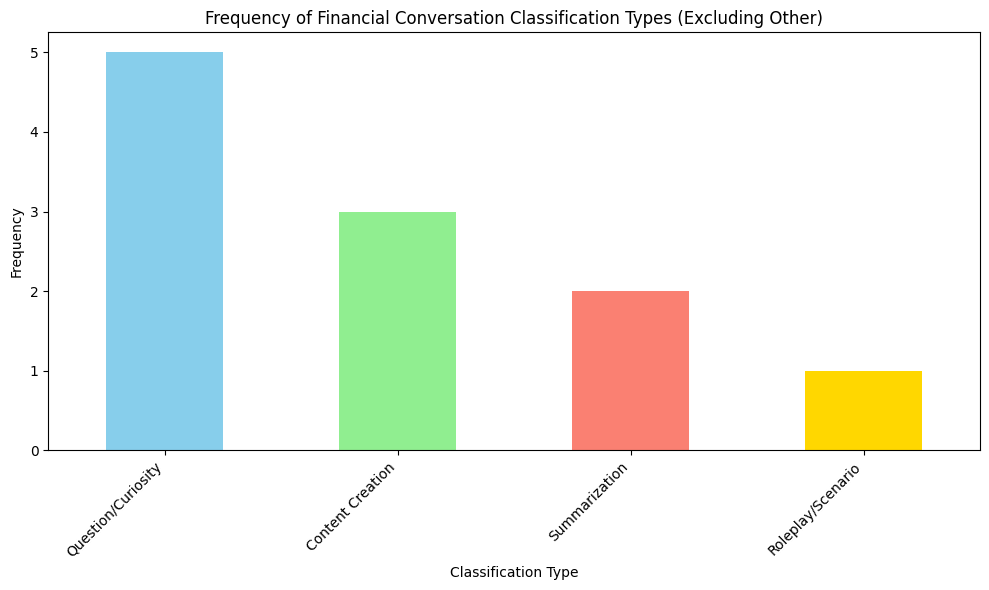

In [43]:
import matplotlib.pyplot as plt

# Create the bar plot
plt.figure(figsize=(10, 6)) # Adjust figure size for better readability
classification_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon', 'gold'])

# Label axes and add a title
plt.xlabel('Classification Type')
plt.ylabel('Frequency')
plt.title('Frequency of Financial Conversation Classification Types (Excluding Other)')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right') # Rotate labels by 45 degrees and align to the right

# Ensure layout is tight to prevent labels overlapping
plt.tight_layout()

# Display the plot
plt.show()